In [1]:
MAX_EPOCHS = 1000
PATIENCE = 50
normalize = False

ITEM = "Osmumten's fang"

INPUT_WIDTH=30
LABEL_WIDTH=30

# LABEL_COLUMNS=['average','avgHighPrice', 'avgLowPrice']
# LABEL_COLUMNS=['average','avgHighPrice', 'avgLowPrice','lowPriceVolume', 'highPriceVolume']
LABEL_COLUMNS=['average']
CONV_WIDTH = 30 # given x stamps, predict 1 in the future


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import DateTimeHelper
import HistoricalDataHelper

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Get Data

In [3]:
df = DateTimeHelper.getDT(ITEM, "6h")
df

,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,average
timestamp,,,,,
2023-01-07 12:00:00,63863742,63245417,400,362,6.357000e+07
2023-01-07 18:00:00,63850441,63385970,414,495,6.359751e+07
2023-01-08 00:00:00,63873374,63543631,401,523,6.368673e+07
2023-01-08 06:00:00,63833764,63329228,279,351,6.355267e+07
2023-01-08 12:00:00,63789883,63316819,345,406,6.353414e+07
...,...,...,...,...,...
2023-04-07 12:00:00,41773077,41304624,523,527,4.153796e+07
2023-04-07 18:00:00,41713707,41256492,632,683,4.147623e+07
2023-04-08 00:00:00,41886996,41534539,362,600,4.166717e+07


## Append Historical Data

In [4]:
# import the Historical data
test = HistoricalDataHelper.get_historical(ITEM)
print(test.empty)

id is  26219
No info for timestamp 1670604380.784718  continuing until 10 in a row with no info: 1 /10
No info for timestamp 1669740380.784718  continuing until 10 in a row with no info: 1 /10
No info for timestamp 1669049180.784718  continuing until 10 in a row with no info: 1 /10
No info for timestamp 1661186780.784718  continuing until 10 in a row with no info: 1 /10
No info for timestamp 1661100380.784718  continuing until 10 in a row with no info: 2 /10
No info for timestamp 1661013980.784718  continuing until 10 in a row with no info: 3 /10
No info for timestamp 1660927580.784718  continuing until 10 in a row with no info: 4 /10
No info for timestamp 1660841180.784718  continuing until 10 in a row with no info: 5 /10
No info for timestamp 1660754780.784718  continuing until 10 in a row with no info: 6 /10
No info for timestamp 1660668380.784718  continuing until 10 in a row with no info: 7 /10
No info for timestamp 1660581980.784718  continuing until 10 in a row with no info: 8 /

In [5]:
if not test.empty:
    test = test.transpose()
    test = test[['avgHighPrice', 'avgLowPrice', 'highPriceVolume', 'lowPriceVolume']]
    test= DateTimeHelper.addAverage(test)
    test.index.name = "timestamp"
    # now we append the historical data to the curr data
    # df = df.append(test)
    df = pd.concat([df,test])
    df

# Prepare Data

In [6]:
df2 = df.copy()

layer = tf.keras.layers.Normalization(invert=True)
layer.adapt(df)

df = DateTimeHelper.addAverage(df)

if(normalize):
    df = tf.keras.utils.normalize(df)

print(np.any(np.isnan(df)))
df

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-08 15:47:09.348275: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


False


,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,average
timestamp,,,,,
2023-01-07 12:00:00,63863742,63245417,400,362,6.357000e+07
2023-01-07 18:00:00,63850441,63385970,414,495,6.359751e+07
2023-01-08 00:00:00,63873374,63543631,401,523,6.368673e+07
2023-01-08 06:00:00,63833764,63329228,279,351,6.355267e+07
2023-01-08 12:00:00,63789883,63316819,345,406,6.353414e+07
...,...,...,...,...,...
2022-08-28 12:00:00,245532547,247505333,375,510,2.466694e+08
2022-08-27 12:00:00,318575098,315878954,316,380,3.171031e+08
2022-08-26 12:00:00,448538203,443684245,234,307,4.457837e+08


In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

df = df.reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df = df.sort_index()

n = len(df)
print(n)
print(len(df2))
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
og_test_df = df2[int(n*0.9):]

num_features = df.shape[1]

499
499


# Window Generator Class

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    # self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
def plot(self, model=None, plot_col='average', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [11]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [12]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# ML

## Define Fit

In [13]:
def compile_and_fit(model:tf.keras.models.Sequential, window, patience=PATIENCE):
# Include the epoch in the file name (uses `str.format`)
  checkpoint_path = "Models/cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  
  batch_size = 32
  
  # Create a callback that saves the model's weights every 5 epochs
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path, 
      verbose=1, 
      save_weights_only=True,
      save_freq=100*batch_size)
  
  early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    start_from_epoch=MAX_EPOCHS/5,
                                                    mode='min')
  early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                    patience=patience,
                                                    start_from_epoch=MAX_EPOCHS/5,
                                                    mode='min')
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping1, early_stopping2, cp_callback])
  return history

## Setup ML/Windows

In [14]:
window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,
    label_columns=LABEL_COLUMNS)
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['average']

In [15]:
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['average'])
conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['average']

In [16]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['average'])

wide_conv_window

Total window size: 54
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]
Label column name(s): ['average']

# Linear

In [17]:
# linear
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [18]:
# history = linear.load_weights('Model/linear_cp.ckpt')
history = compile_and_fit(linear, window)

Epoch 1/1000
10/10 [==============================] - 1s 24ms/step - loss: 8737975135371264.0000 - mean_absolute_error: 77013352.0000 - val_loss: 2261694076157952.0000 - val_mean_absolute_error: 47550380.0000
Epoch 2/1000
10/10 [==============================] - 0s 13ms/step - loss: 8266167072325632.0000 - mean_absolute_error: 74809440.0000 - val_loss: 2131091100008448.0000 - val_mean_absolute_error: 46157024.0000
Epoch 3/1000
10/10 [==============================] - 0s 15ms/step - loss: 7765867806851072.0000 - mean_absolute_error: 72590872.0000 - val_loss: 2009921482653696.0000 - val_mean_absolute_error: 44825588.0000
Epoch 4/1000
10/10 [==============================] - 0s 10ms/step - loss: 7316943329558528.0000 - mean_absolute_error: 70454440.0000 - val_loss: 1891366426640384.0000 - val_mean_absolute_error: 43483448.0000
Epoch 5/1000
10/10 [==============================] - 0s 11ms/step - loss: 6876330687725568.0000 - mean_absolute_error: 68311880.0000 - val_loss: 1778953710731264.0

In [19]:
# wide_window.plot(linear)
y_pred = linear.predict(test_df)
for i in range(len(y_pred)):

    if normalize:
        print("" + str(np.array(layer(y_pred[i]))[0][4]) + " vs " + str(np.array(layer(test_df['average'][i]))[0][4]) + " vs " + str(og_test_df['average'][i]))
    else:
        print("" + str(y_pred[i][0]) + " vs " + str(test_df['average'][i]))

2/2 [==============================] - 0s 8ms/step
41125252.0 vs 42025877.483412325
40357132.0 vs 41254617.04057971
40130536.0 vs 41019399.48015564
40122280.0 vs 41010184.551233396
39731280.0 vs 40596132.469135806
39618360.0 vs 40494948.84529148
39809628.0 vs 40693849.494281046
39853016.0 vs 40734284.52380952
39644780.0 vs 40498287.536203526
39850830.0 vs 40710149.51792336
39857550.0 vs 40708673.16470588
40556612.0 vs 41449408.21377184
40545884.0 vs 41442843.11892797
40853504.0 vs 41756825.47246022
40944316.0 vs 41832310.22980251
40879030.0 vs 41769879.95583239
40589776.0 vs 41489796.65969582
40609636.0 vs 41501166.03202847
40602876.0 vs 41484841.85045045
40597156.0 vs 41479238.8618677
40475932.0 vs 41358865.280135825
40793188.0 vs 41679985.08324206
40723570.0 vs 41599604.07542579
40509480.0 vs 41378999.4
40331652.0 vs 41207256.60080645
40526684.0 vs 41395339.35602094
40901404.0 vs 41788850.241483726
41025628.0 vs 41912159.687927105
41031850.0 vs 41931361.975736566
40974036.0 vs 418676

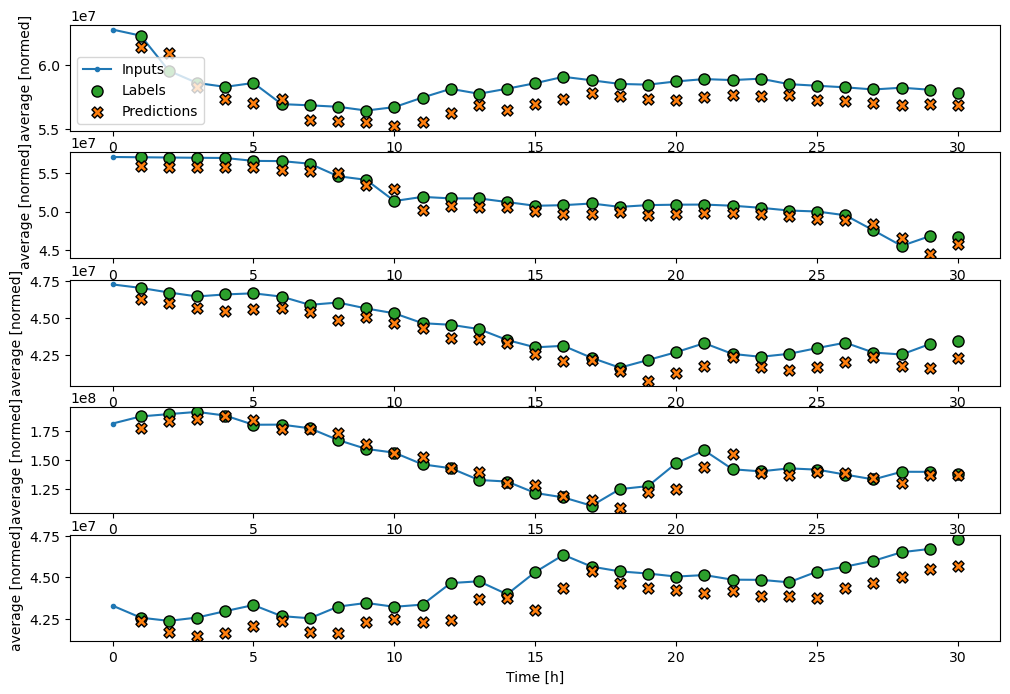

In [20]:
window.plot(linear)

<Axes: xlabel='timestamp'>

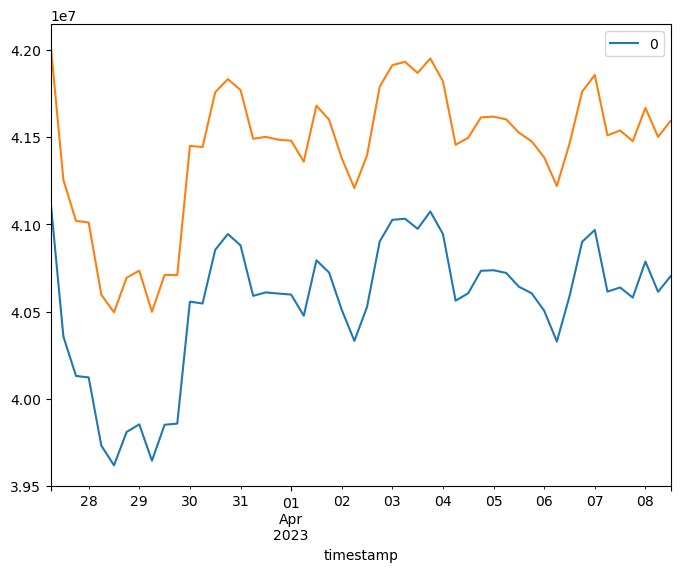

In [21]:
p = pd.DataFrame(y_pred)
p = p.reset_index()
for i in range(len(p)):
    p.loc[i,'index'] = test_df.index[i]
p= p.set_index('index')

p.plot()
test_df['average'].plot()

In [22]:
linear.save('Models/Linear')

INFO:tensorflow:Assets written to: Models/Linear/assets


# Multi-Step Dense

In [23]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [24]:
history = compile_and_fit(multi_step_dense, conv_window)

Epoch 1/1000
10/10 [==============================] - 1s 36ms/step - loss: 368880916627456.0000 - mean_absolute_error: 15040453.0000 - val_loss: 123410197774336.0000 - val_mean_absolute_error: 11058293.0000
Epoch 2/1000
10/10 [==============================] - 0s 10ms/step - loss: 157645650526208.0000 - mean_absolute_error: 8451143.0000 - val_loss: 5812257816576.0000 - val_mean_absolute_error: 2244975.0000
Epoch 3/1000
10/10 [==============================] - 0s 11ms/step - loss: 110629364957184.0000 - mean_absolute_error: 5898982.5000 - val_loss: 713789603840.0000 - val_mean_absolute_error: 660941.1250
Epoch 4/1000
10/10 [==============================] - 0s 12ms/step - loss: 95845844254720.0000 - mean_absolute_error: 5495085.0000 - val_loss: 727130112000.0000 - val_mean_absolute_error: 680404.9375
Epoch 5/1000
10/10 [==============================] - 0s 12ms/step - loss: 83004982558720.0000 - mean_absolute_error: 5169551.5000 - val_loss: 28042114105344.0000 - val_mean_absolute_error:

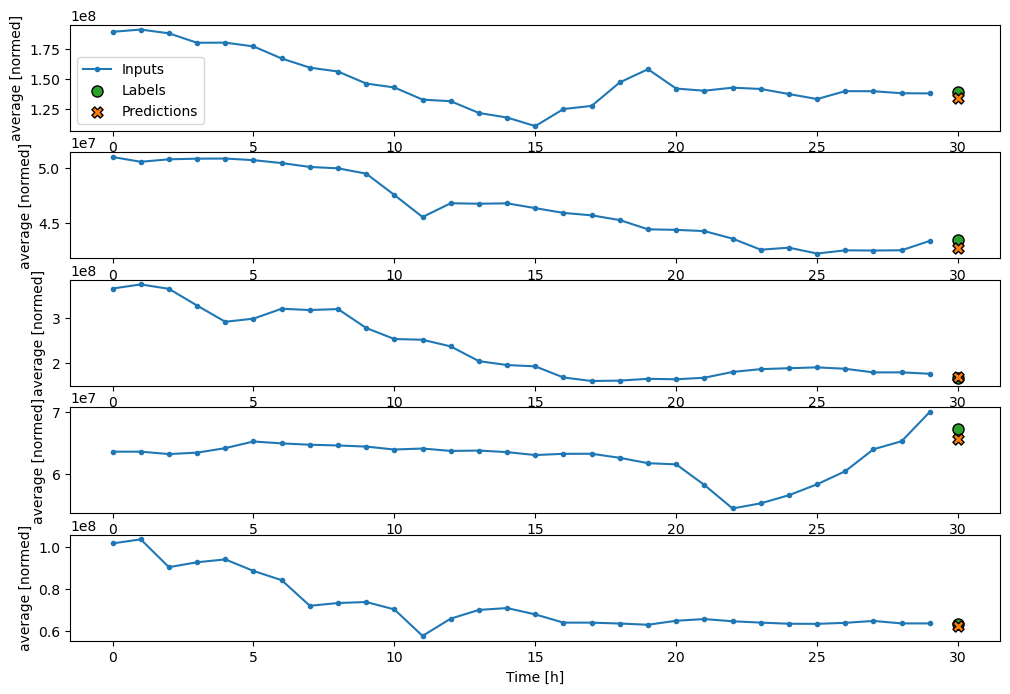

In [25]:
conv_window.plot(multi_step_dense)

In [26]:
multi_step_dense.save('Models/Multi_Step_Dense')

INFO:tensorflow:Assets written to: Models/Multi_Step_Dense/assets


# Conv1D

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

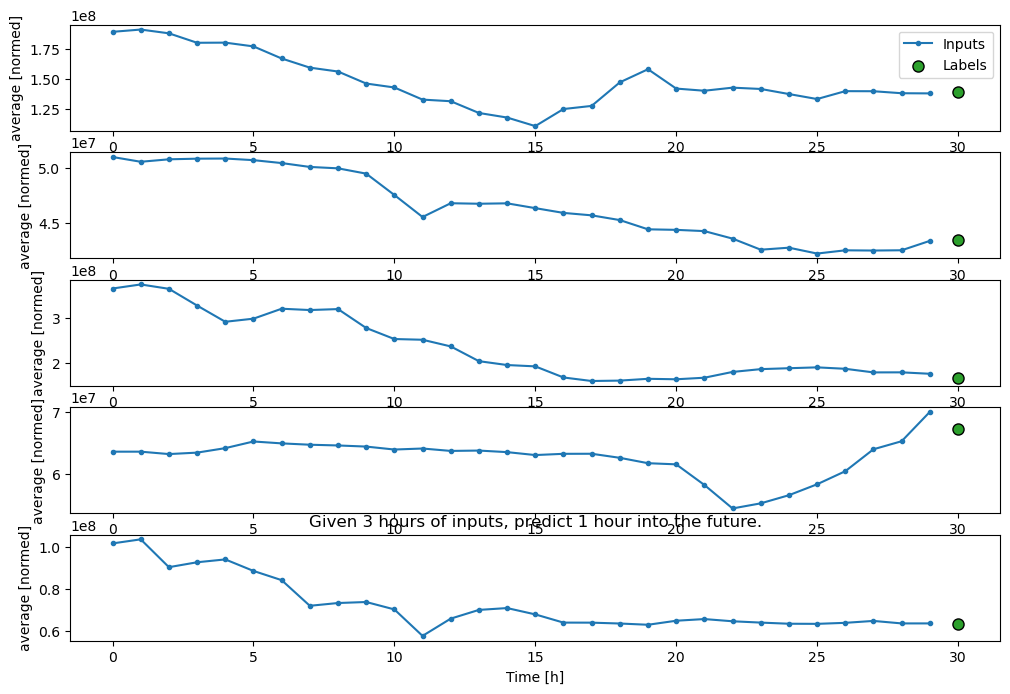

In [27]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [28]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/1000
10/10 [==============================] - 1s 32ms/step - loss: 371313713610752.0000 - mean_absolute_error: 14607628.0000 - val_loss: 150031277490176.0000 - val_mean_absolute_error: 12215887.0000
Epoch 2/1000
10/10 [==============================] - 0s 16ms/step - loss: 162575232794624.0000 - mean_absolute_error: 8841195.0000 - val_loss: 35809369522176.0000 - val_mean_absolute_error: 5932684.0000
Epoch 3/1000
10/10 [==============================] - 0s 13ms/step - loss: 151216017375232.0000 - mean_absolute_error: 10472902.0000 - val_loss: 805297782784.0000 - val_mean_absolute_error: 767516.0625
Epoch 4/1000
10/10 [==============================] - 0s 13ms/step - loss: 135609163186176.0000 - mean_absolute_error: 7325204.0000 - val_loss: 72811213225984.0000 - val_mean_absolute_error: 8502416.0000
Epoch 5/1000
10/10 [==============================] - 0s 14ms/step - loss: 84969955262464.0000 - mean_absolute_error: 6860093.0000 - val_loss: 15229368926208.0000 - val_mean_absolute_

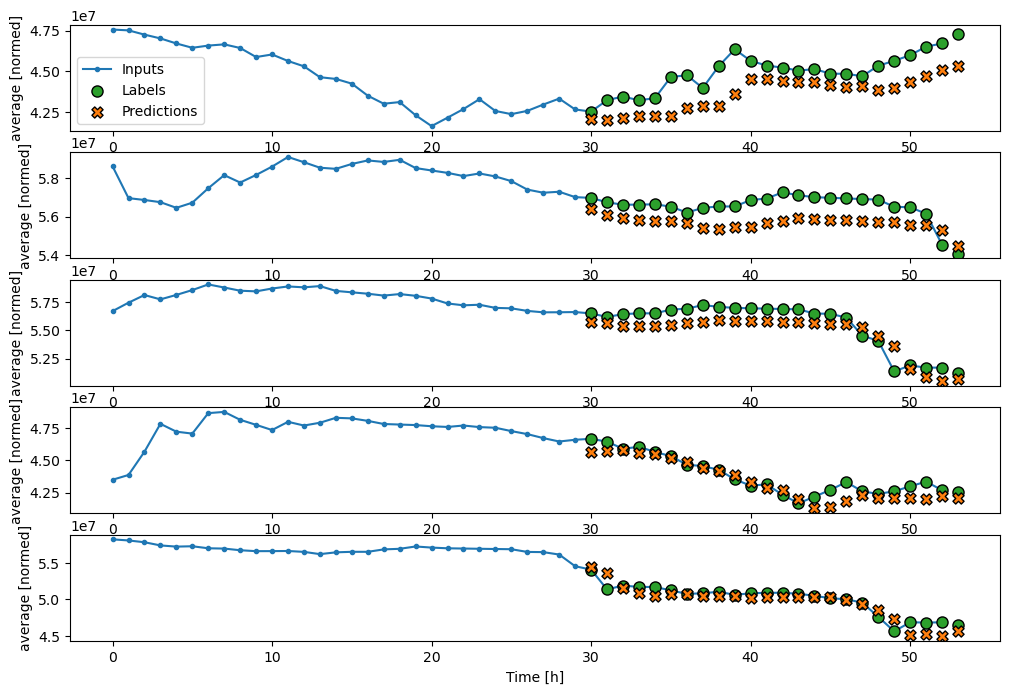

In [29]:
wide_conv_window.plot(conv_model)

In [30]:
conv_model.save('Models/Conv_Model')

INFO:tensorflow:Assets written to: Models/Conv_Model/assets


INFO:tensorflow:Assets written to: Models/Conv_Model/assets


In [31]:
"""
# wide_window.plot(linear)
# test_df = tf.expand_dims(test_df, axis=-1)
y_pred = conv_model.predict(test_df)
for i in range(len(y_pred)):

    if normalize:
        print("" + str(np.array(layer(y_pred[i]))[0][4]) + " vs " + str(np.array(layer(test_df['average'][i]))[0][4]) + " vs " + str(og_test_df['average'][i]))
    else:
        print("" + str(y_pred[i][0]) + " vs " + str(test_df['average'][i]))

p = pd.DataFrame(y_pred)
p = p.reset_index()
for i in range(len(p)):
    p.loc[i,'index'] = test_df.index[i]
p= p.set_index('index')

p.plot()
test_df['average'].plot()
"""

'\n# wide_window.plot(linear)\n# test_df = tf.expand_dims(test_df, axis=-1)\ny_pred = conv_model.predict(test_df)\nfor i in range(len(y_pred)):\n\n    if normalize:\n        print("" + str(np.array(layer(y_pred[i]))[0][4]) + " vs " + str(np.array(layer(test_df[\'average\'][i]))[0][4]) + " vs " + str(og_test_df[\'average\'][i]))\n    else:\n        print("" + str(y_pred[i][0]) + " vs " + str(test_df[\'average\'][i]))\n\np = pd.DataFrame(y_pred)\np = p.reset_index()\nfor i in range(len(p)):\n    p.loc[i,\'index\'] = test_df.index[i]\np= p.set_index(\'index\')\n\np.plot()\ntest_df[\'average\'].plot()\n'

In [32]:
new_model = tf.keras.models.load_model('Models/Linear')